# Transects with different seasonal averages
This notebook is a follow-on from the temp_density_transects.ipynb notebook, in which the location of the transects are chosen. Here we want to focus on how the temp/salt/isopycnals change in different seasons in the regions with surface warming/bottom cooling (e.g. Amundsen/Totten etc).

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.colors as col
import matplotlib.path as mpath
from mpl_toolkits.axes_grid1 import make_axes_locatable

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
figdir = '/g/data/v45/akm157/figures/easterlies/transects/seasonal/'

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:43021 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 188.57 GiB


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# database for perturbations:
easterlies_session = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
# 10% increase in easterly wind speed:
easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
# 10% decrease in easterly wind speed:
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'

# plot anomalies for last 5 years of simulation:
start_time='2160-01-01'
end_time='2164-12-31'

lat_slice  = slice(-80,-50)

In [4]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=13

## Transects
Just pick locations where we can use north-south transects

In [6]:
zlevel1 = 0
zlevel2 = 1600

first_year = '2155'
last_year = '2159'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

# just use sample data to get month_length and weights:
temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
temp_con_transect = temp_con_transect.sel(xt_ocean=100,method='nearest').sel(yt_ocean=-60,method='nearest').sel(time=slice(start_time,end_time)).sel(st_ocean=0,method='nearest')
month_length = temp_con_transect.time.dt.days_in_month
# Calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()
weights = weights.load()

def get_transect_data(lon,lat1,lat2):
    lat_slice  = slice(lat1, lat2)

    # import bathymetry:
    ht_transect = cc.querying.getvar(control,'ht',master_session,n=1)
    ht_transect = ht_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice)
    ht_transect = ht_transect.load()
    ht_transect[np.isnan(ht_transect)] = 0

    ### load data for this period:
    temp_con_transect = cc.querying.getvar(control,'temp' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_con_transect = temp_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    temp_con_transect = (temp_con_transect * weights).groupby('time.season').sum(dim='time')
    temp_con_transect = temp_con_transect
    # need to mask land again:
    temp_con_transect = temp_con_transect.where(temp_con_transect!=0).load()

    temp_up_transect = cc.querying.getvar(easterlies_up,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_up_transect = temp_up_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    temp_up_transect = (temp_up_transect * weights).groupby('time.season').sum(dim='time')
    temp_up_transect = temp_up_transect
    # need to mask land again:
    temp_up_transect = temp_up_transect.where(temp_up_transect!=0).load()

    temp_down_transect = cc.querying.getvar(easterlies_down,'temp' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
    temp_down_transect = temp_down_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    temp_down_transect = (temp_down_transect * weights).groupby('time.season').sum(dim='time')
    temp_down_transect = temp_down_transect
    # need to mask land again:
    temp_down_transect = temp_down_transect.where(temp_down_transect!=0).load()

    ### load data for this period:
    salt_con_transect = cc.querying.getvar(control,'salt' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_con_transect = salt_con_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    salt_con_transect = (salt_con_transect * weights).groupby('time.season').sum(dim='time')
    salt_con_transect = salt_con_transect
    # need to mask land again:
    salt_con_transect = salt_con_transect.where(salt_con_transect>0).load()

    salt_up_transect = cc.querying.getvar(easterlies_up,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_up_transect = salt_up_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    salt_up_transect = (salt_up_transect * weights).groupby('time.season').sum(dim='time')
    salt_up_transect = salt_up_transect
    # need to mask land again:
    salt_up_transect = salt_up_transect.where(salt_up_transect>0).load()

    salt_down_transect = cc.querying.getvar(easterlies_down,'salt' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    salt_down_transect = salt_down_transect.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    salt_down_transect = (salt_down_transect * weights).groupby('time.season').sum(dim='time')
    salt_down_transect = salt_down_transect
    # need to mask land again:
    salt_down_transect = salt_down_transect.where(salt_down_transect>0).load()

    ### also get density for plotting isopycnals:
    rho0_con = cc.querying.getvar(control,'pot_rho_0' , master_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_con = rho0_con.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    rho0_con = (rho0_con * weights).groupby('time.season').sum(dim='time')
    rho0_con = rho0_con
    # need to mask land again:
    rho0_con = rho0_con.where(rho0_con>0).load()

    rho0_up = cc.querying.getvar(easterlies_up,'pot_rho_0' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_up = rho0_up.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    rho0_up = (rho0_up * weights).groupby('time.season').sum(dim='time')
    rho0_up = rho0_up
    # need to mask land again:
    rho0_up = rho0_up.where(rho0_up>0).load()

    rho0_down = cc.querying.getvar(easterlies_down,'pot_rho_0' , easterlies_session,frequency='1 monthly',start_time=start_time, end_time=end_time)
    rho0_down = rho0_down.sel(xt_ocean=lon,method='nearest').sel(yt_ocean=lat_slice).sel(time=slice(start_time,end_time)).sel(st_ocean=slice(zlevel1,zlevel2))
    # Calculate the weighted seasonal average
    rho0_down = (rho0_down * weights).groupby('time.season').sum(dim='time')
    rho0_down = rho0_down
    # need to mask land again:
    rho0_down = rho0_down.where(rho0_down>0).load()
    
    return ht_transect,temp_con_transect,temp_up_transect,temp_down_transect,salt_con_transect,salt_up_transect,salt_down_transect,rho0_con,rho0_up,rho0_down

In [18]:
# CHANGE THIS, so the plots are: UP all 4 seasons temp and salt anomalies, then on a separate figure do DOWN same.

def plot_transects(region):

    if region == 'AmundsenW':
        lon = -135
        lat1 = -74.7
        lat2 = -73
    elif region == 'AmundsenE':
        lon = -107
        lat1 = -75
        lat2 = -70
    elif region == 'Mertz':
        lon = -220
        lat1 = -66.8
        lat2 = -64.5
    elif region == 'Totten':
        lon = -242
        lat1 = -67.2
        lat2 = -64
    elif region == 'Vincennes':
        lon = -253
        lat1 = -67
        lat2 = -63
    elif region == 'PrydzE':
        lon = 60
        lat1 = -67.5
        lat2 = -64    
    elif region == 'PrydzW':
        lon = 35.5
        lat1 = -69.5
        lat2 = -66 

    ht_transect,temp_con_transect,temp_up_transect,temp_down_transect,salt_con_transect,salt_up_transect,salt_down_transect,rho0_con,rho0_up,rho0_down = get_transect_data(lon,lat1,lat2+.1)

    fontsize=16

    fig=plt.figure(figsize=(20,12))

    scale_max = 0.4

    density_contours = [1027.5,1027.6,1027.72,1027.78,1027.81,1027.83,1027.835,1027.84,1027.845,1027.85]

    #### Up temp DJF:
    season = 'DJF'
    plt.subplot(2,4,1)
    norm = col.Normalize(vmin=-.4,vmax=.4)
    levels=np.arange(-.4,.405,.005)
    ticks = [-.4,-.2,0,.2,.4]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(region+', longitude='+str(lon)+', '+season,fontsize=fontsize)

    #### Up temp DJF:
    season = 'MAM'
    plt.subplot(2,4,2)
    norm = col.Normalize(vmin=-.4,vmax=.4)
    levels=np.arange(-.4,.405,.005)
    ticks = [-.4,-.2,0,.2,.4]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    #plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    #### Up temp JJA:
    season = 'JJA'
    plt.subplot(2,4,3)
    norm = col.Normalize(vmin=-.4,vmax=.4)
    levels=np.arange(-.4,.405,.005)
    ticks = [-.4,-.2,0,.2,.4]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    #plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    #### Up temp SON:
    season = 'SON'
    plt.subplot(2,4,4)
    norm = col.Normalize(vmin=-.4,vmax=.4)
    levels=np.arange(-.4,.405,.005)
    ticks = [-.4,-.2,0,.2,.4]
    pcm = plt.contourf(temp_con_transect.yt_ocean,temp_con_transect.st_ocean,
                       temp_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       temp_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(temp_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    #plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
    cbar.set_label(r'UP Temperature anomaly ($^\circ$C)',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)

    #### Up salt DJF:
    season = 'DJF'
    plt.subplot(2,4,5)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    #plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)
    
    #### Up salt MAM:
    season = 'MAM'
    plt.subplot(2,4,6)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    #### Up salt JJA:
    season = 'JJA'
    plt.subplot(2,4,7)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    #### Up salt SON:
    season = 'SON'
    plt.subplot(2,4,8)
    norm = col.Normalize(vmin=-.1,vmax=.1)
    levels=np.arange(-.1,.101,.001)
    ticks = [-.1,-.05,0,.05,.1]
    pcm = plt.contourf(salt_con_transect.yt_ocean,salt_con_transect.st_ocean,
                       salt_up_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate')-\
                       salt_con_transect.sel(season=season).interpolate_na(dim='st_ocean',method='nearest',fill_value='extrapolate'),
                       cmap = cmocean.balance, norm = norm,levels=levels,extend='both')
    plt.fill_between(salt_con_transect.yt_ocean,ht_transect,1500,zorder=3,color='darkgrey')
    plt.ylim(1500,0)
    plt.xlim(lat1,lat2)
    plt.xlabel('Latitude',fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)

    # isopycnals:
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_up.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize)
    cont=plt.contour(rho0_con.yt_ocean,rho0_con.st_ocean,rho0_con.sel(season=season),density_contours,
                      colors='k',zorder=2 ,fontsize=fontsize,linestyles='--')

    plt.title(season,fontsize=fontsize)

    # colorbar:
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.2)
    cbar = plt.colorbar(pcm, cax=cax,orientation = 'vertical',extend = 'neither',ticks=ticks)
    cbar.set_label(r'UP Salinity anomaly',fontsize=fontsize,labelpad=5)
    cbar.ax.tick_params(labelsize=fontsize)
    
    plt.tight_layout()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

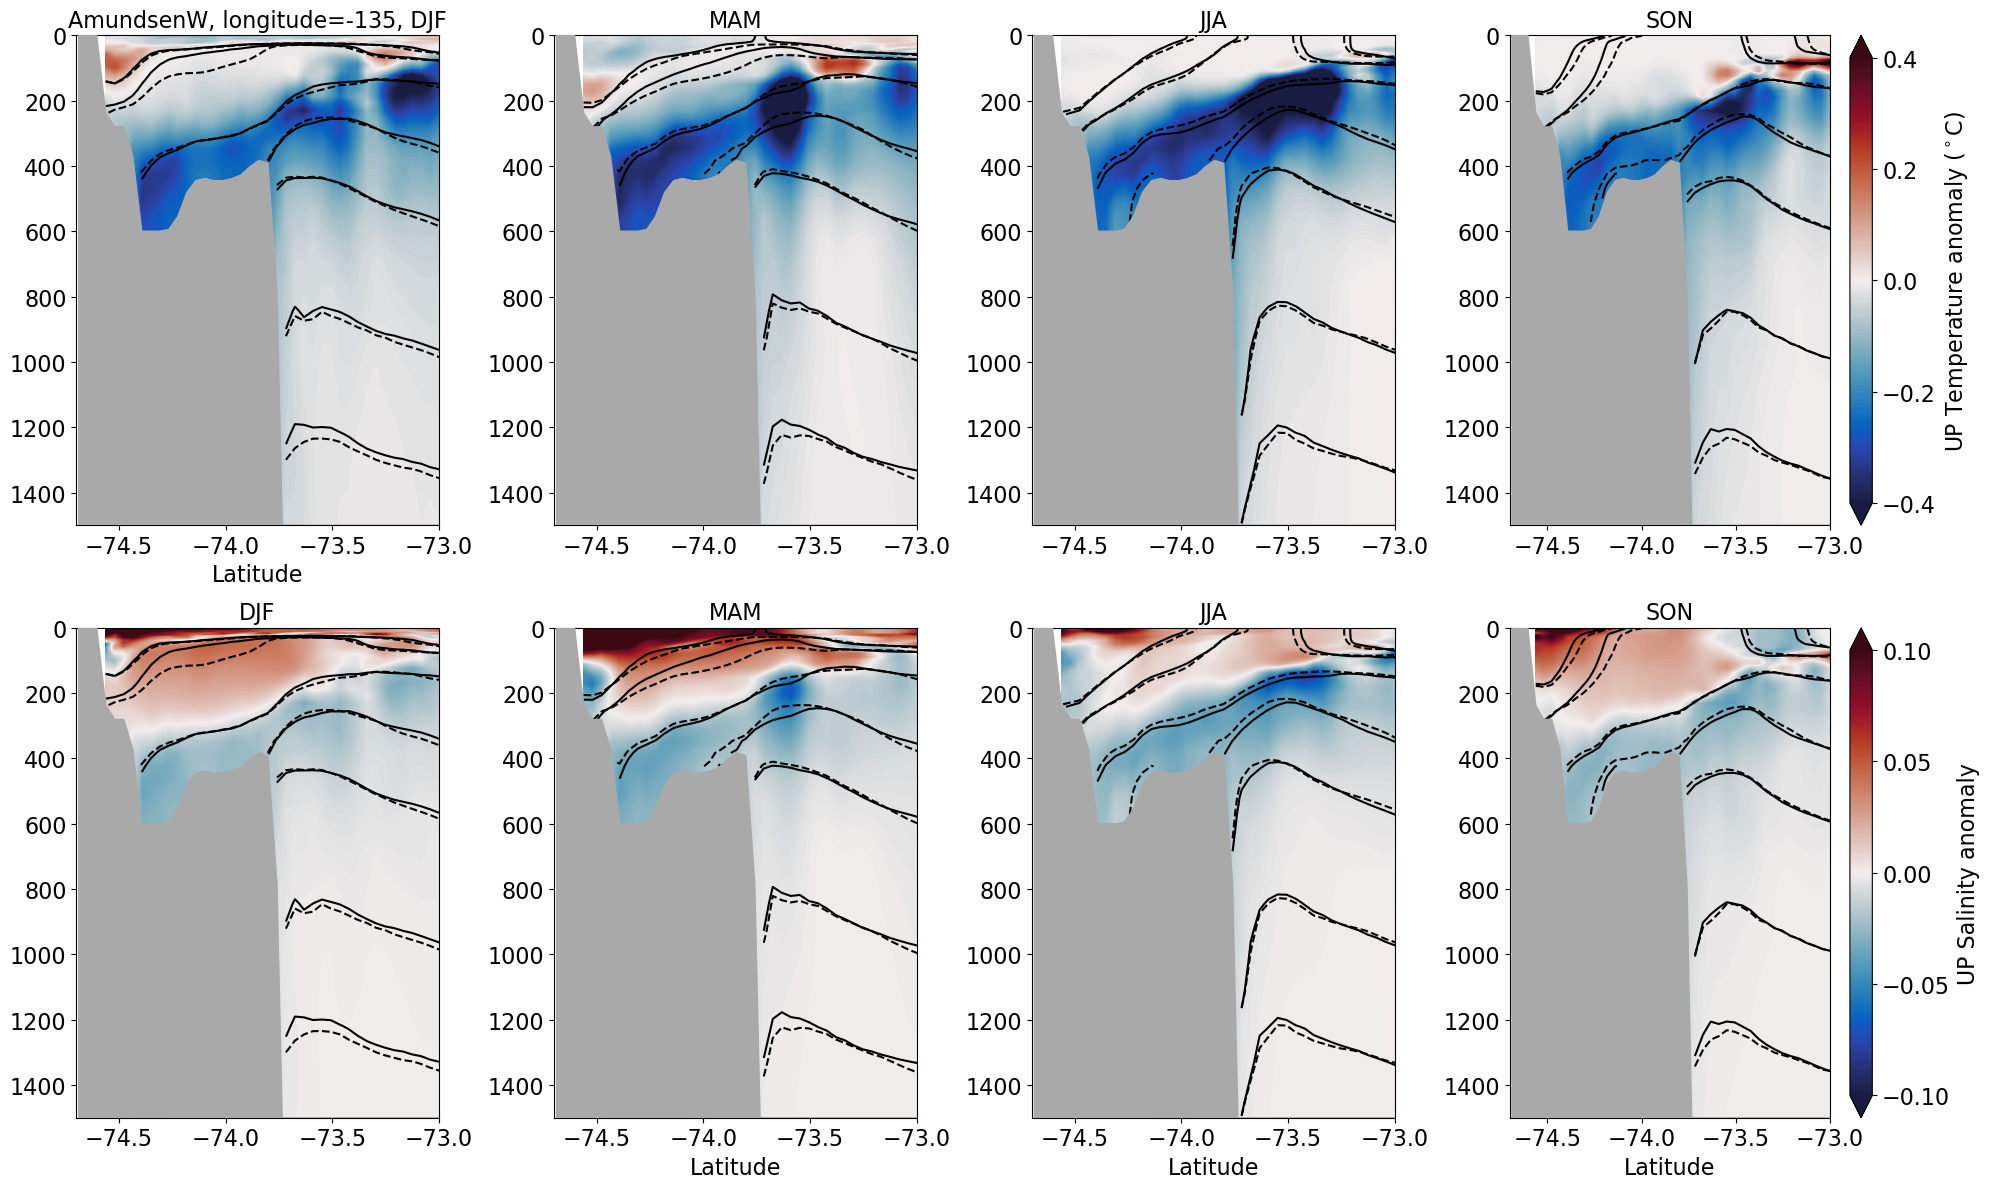

In [19]:
plot_transects('AmundsenW')
figure_path = figdir+'AmundsenW_seasons_UP.png'
plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

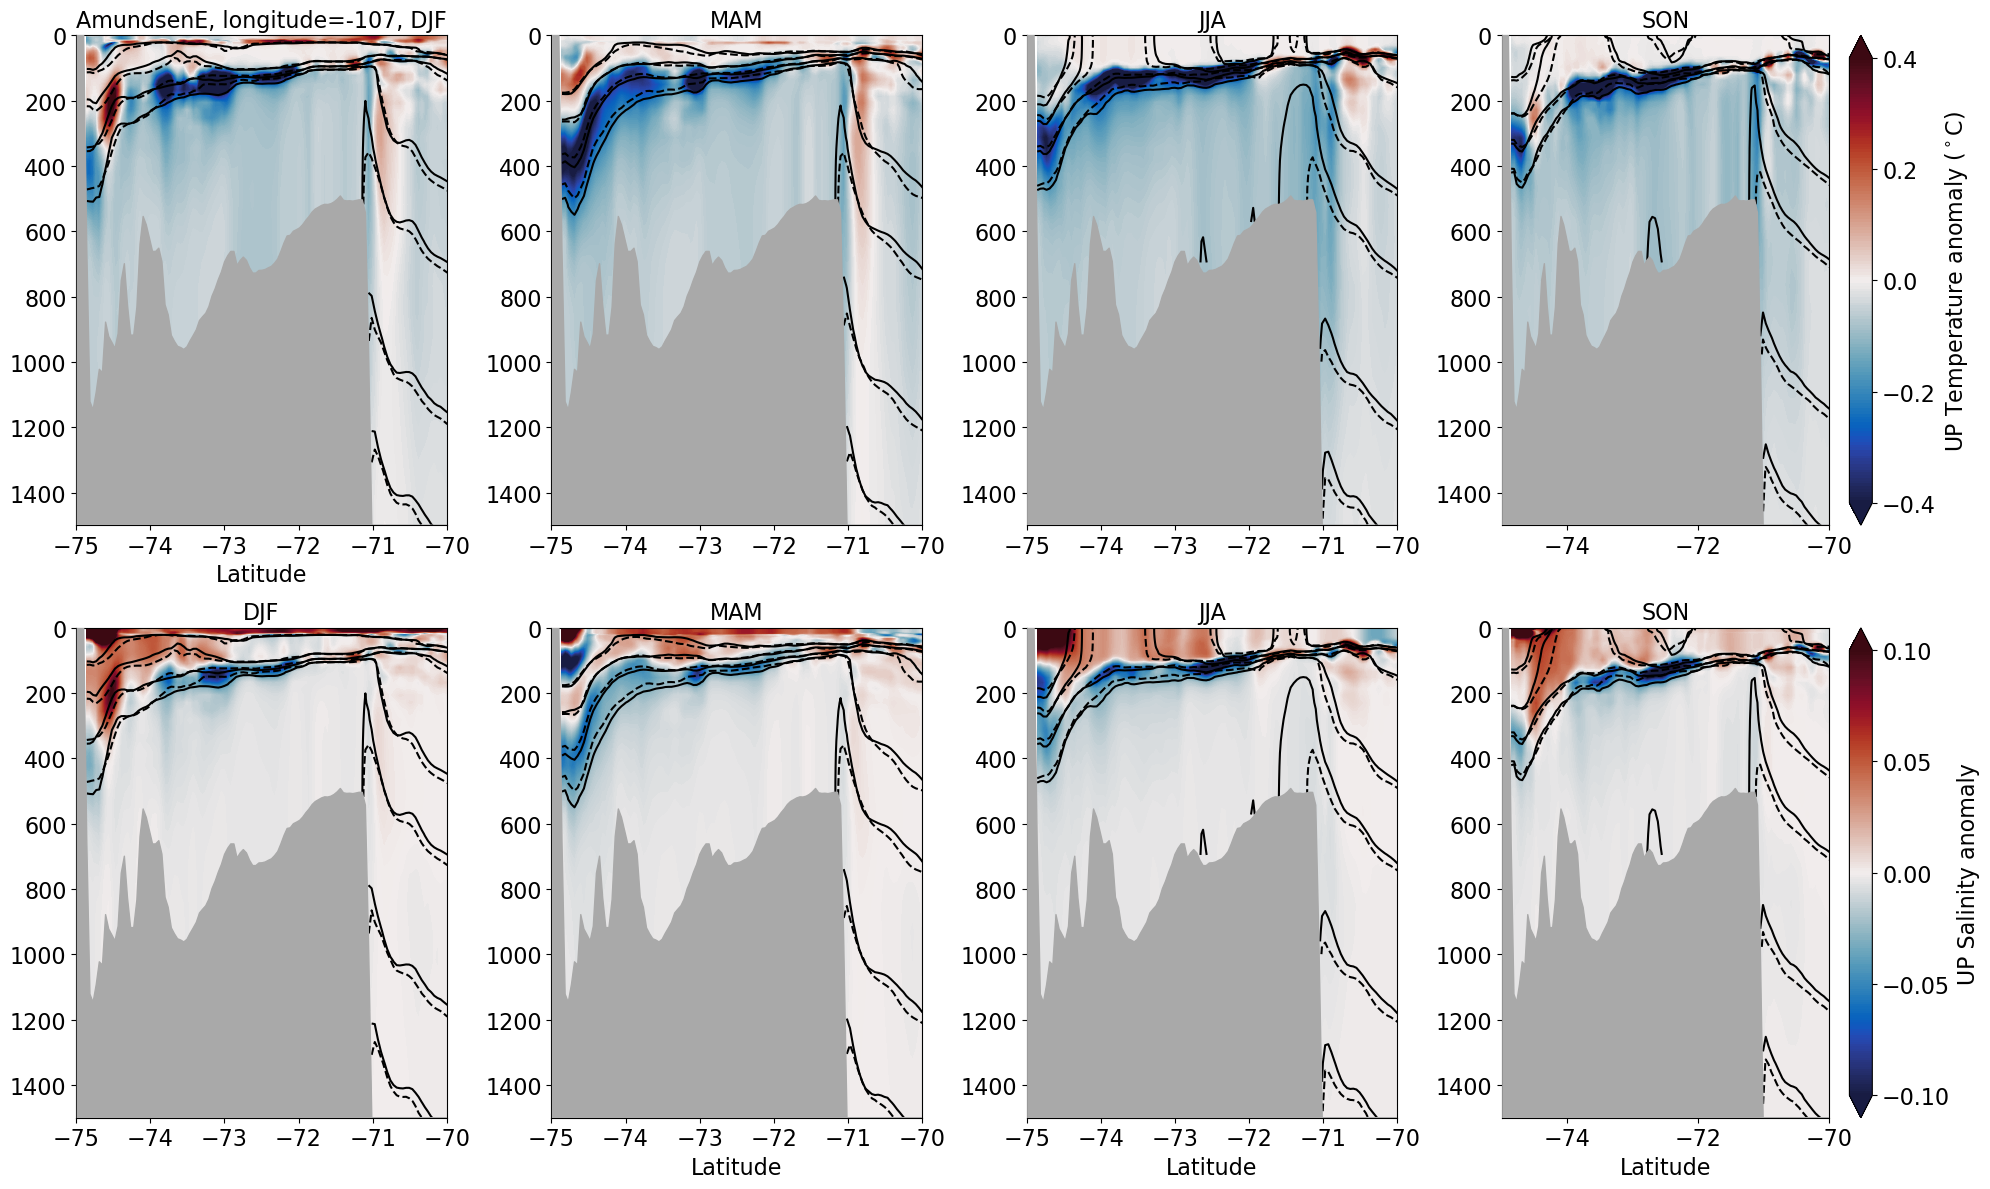

In [20]:
plot_transects('AmundsenE')
figure_path = figdir+'AmundsenE_seasons_UP.png'
plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

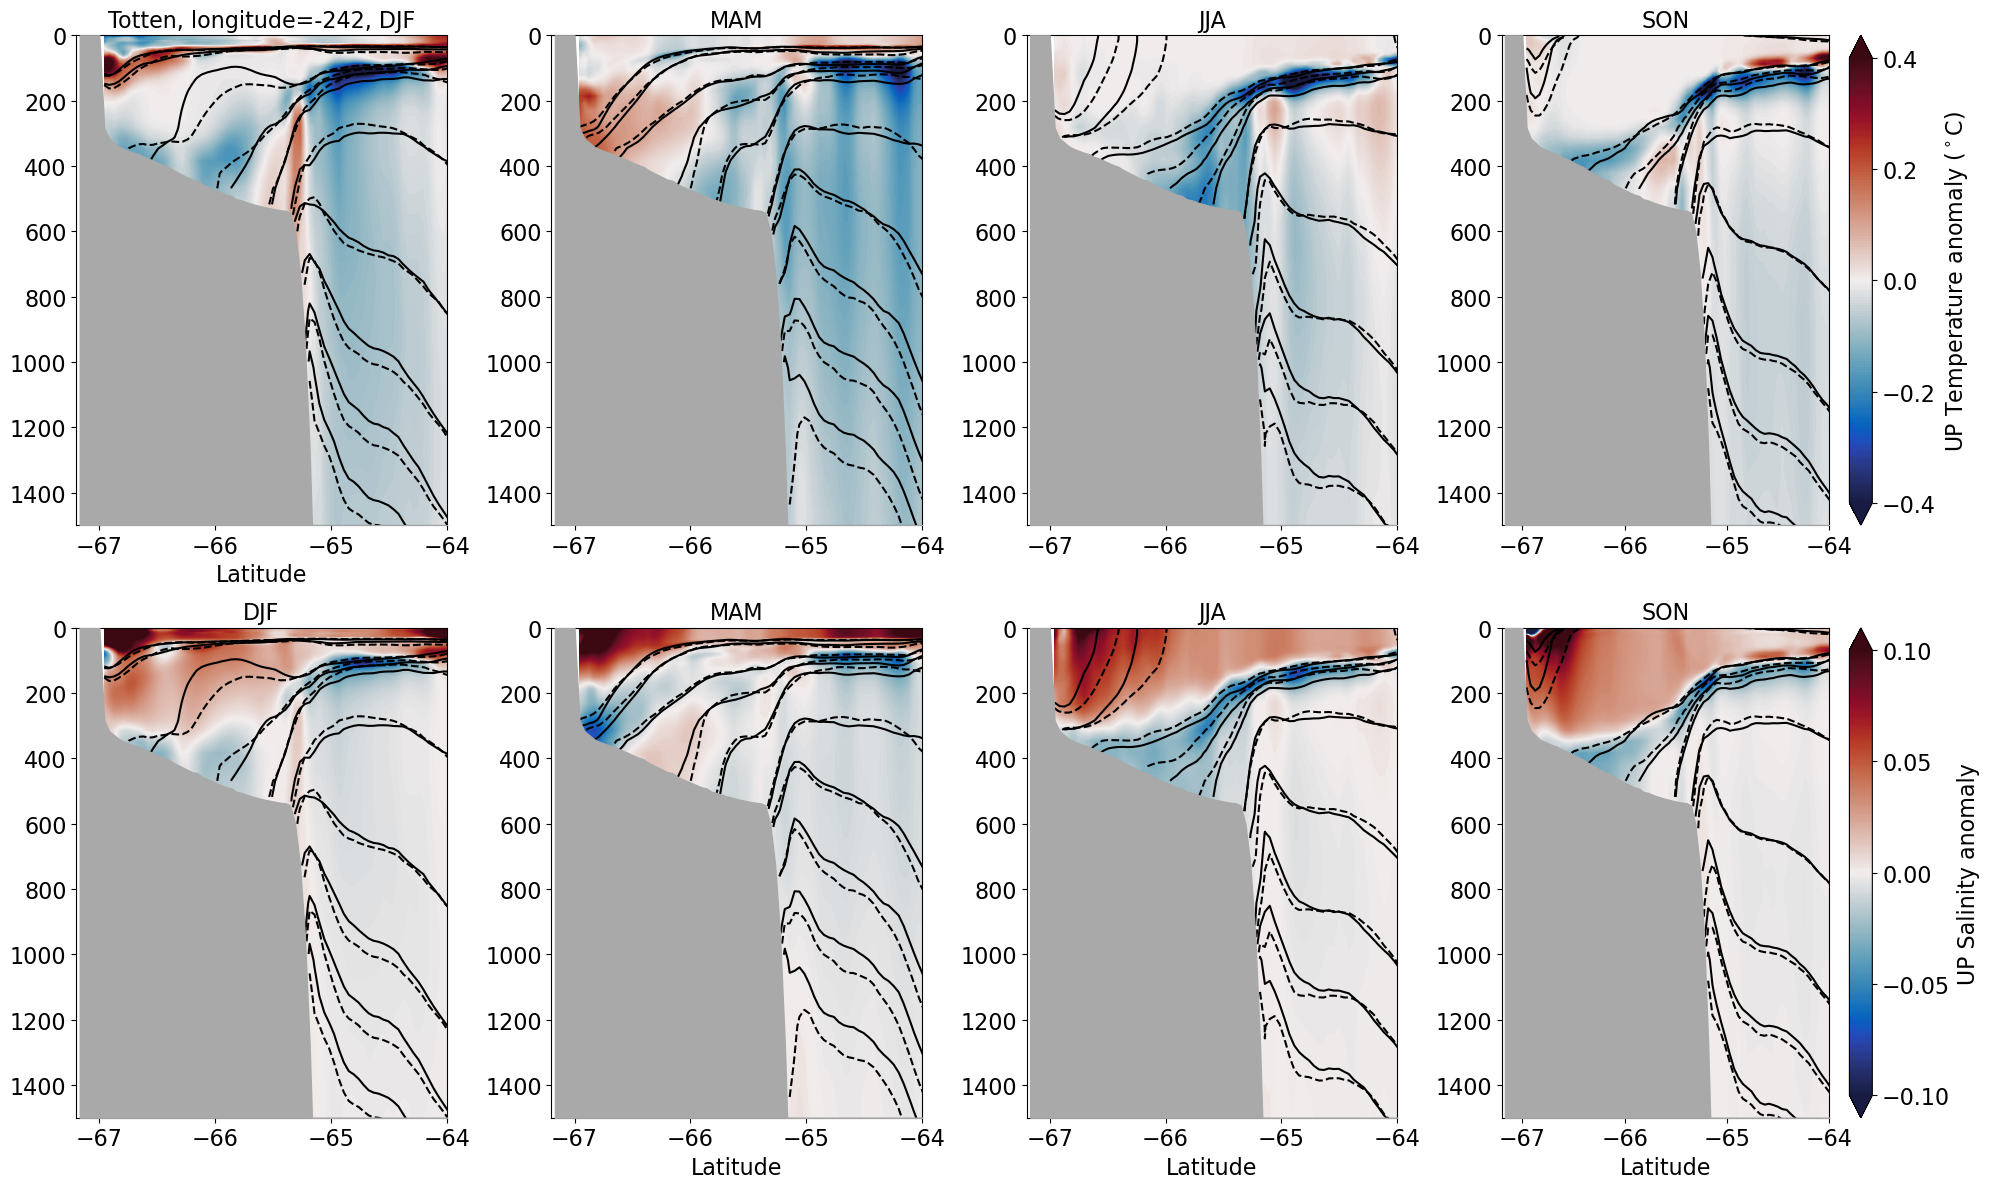

In [21]:
plot_transects('Totten')
figure_path = figdir+'Totten_seasons_UP.png'
plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')

distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

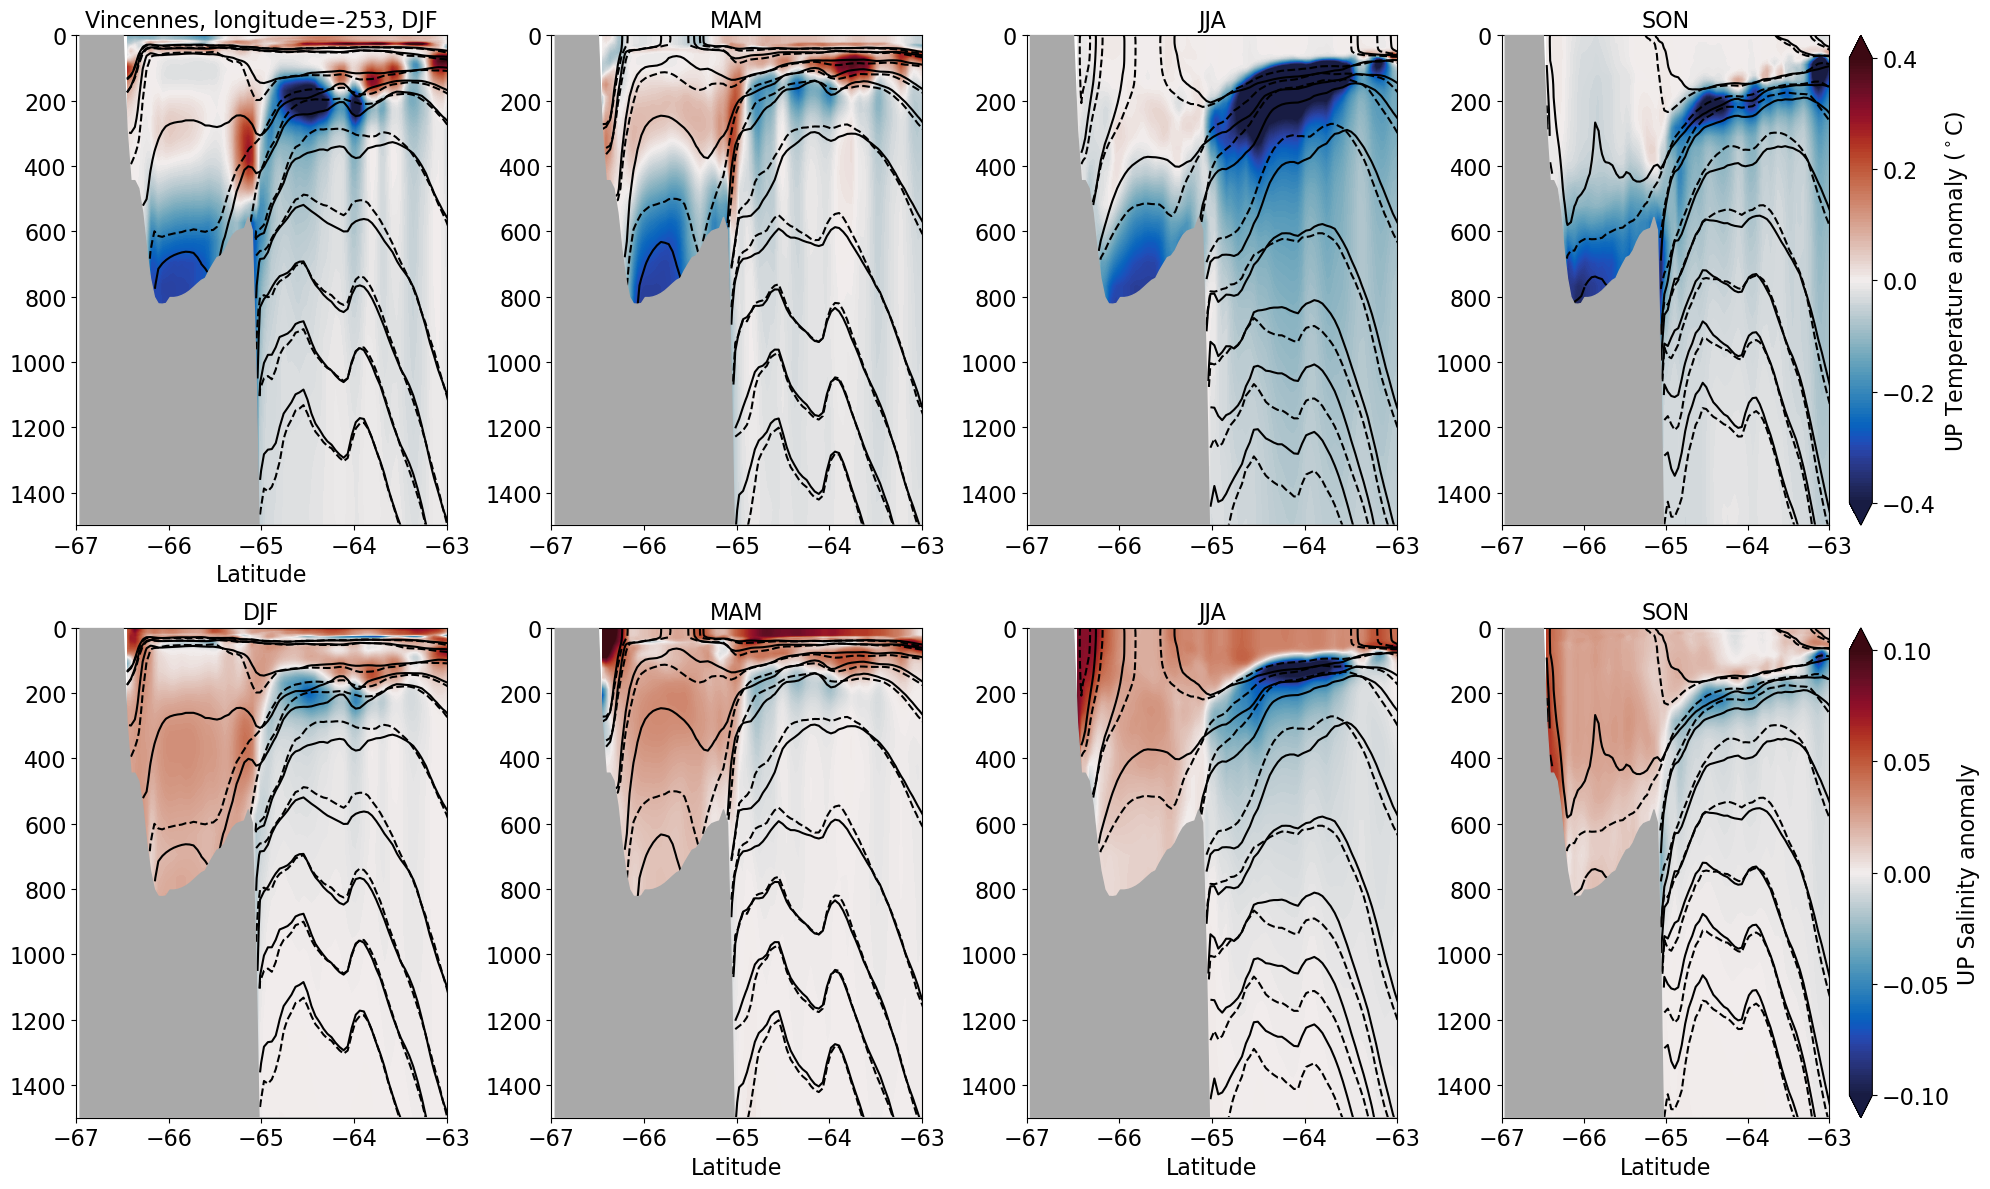

In [22]:
plot_transects('Vincennes')
figure_path = figdir+'Vincennes_seasons_UP.png'
plt.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1,facecolor='white')